In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from library.Benchmark2 import *
import time
from library.Constant import *
from library.LogParser import *
from library.Result import *
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#50GB dataset, 10GB overwrite
def test_data_disk_bulk_and_overwrite_with_compression(test_dir, num_keys = "125000000", 
                                                       num_keys_random = "25000000", run_random = True, 
                                                       write_buffer_size = 128 * MB):
    rocks_db_dir = "/home/fxie/rocksdb"
    print(f"test dir {test_dir}")
    benchmark2 = Benchmark2(rocks_db_dir = rocks_db_dir, test_dir = test_dir)
    benchmark2.para_map["COMPRESSION_TYPE"] = "none"
    benchmark2.para_map["CACHE_SIZE"] = "104857600"
    benchmark2.para_map["NUM_KEYS"] = num_keys
    benchmark2.para_map["WRITE_BUFFER_SIZE"] = write_buffer_size
    benchmark2.bulkload()
        
    #reduce kv num
    if run_random:
        benchmark2.para_map["NUM_KEYS"] = num_keys_random
        benchmark2.overwrite()

        benchmark2.readrandom()
        
    benchmark2.clean_up()   

In [4]:
def plot_bar(disk_names, results, y_label, title, color):
    y_pos = np.arange(len(disk_names))
    plt.bar(y_pos, results, align='center', alpha=0.5, width = 0.3, color = color)
    plt.xticks(y_pos, disk_names)
    plt.ylabel(y_label)
    plt.title(title)
    for i in range(len(results)):
        plt.text(x = y_pos[i] - 0.1 , y = results[i]+0.1, s = results[i], size = 10)
    plt.show()
    
def plot_bar2(y_label, title, metrics_names, disk_results, x_label, disk_names):
    # data to plot
    n_groups = len(disk_names)

    # create plot
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.1
    opacity = 0.8
        
    for i in range(len(metrics_names)):
        plt.bar(index + bar_width * i, disk_results[i], bar_width, alpha=opacity,label=metrics_names[i])
        
            
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(index + bar_width / 2, disk_names)
    plt.legend()
    plt.tight_layout()
    plt.show()
        

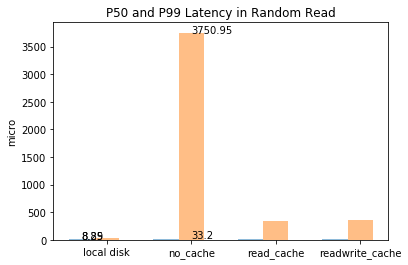

In [57]:
plot_bar3("micro", "P50 and P99 Latency in Random Read", ["P50", "P99"], 
         [[8.85, 8.29, 8.13, 8.23], [33.2, 3750.95, 347.47, 352.23]], 
          "disk names", ["local disk", "no_cache", "read_cache", "readwrite_cache"])

In [5]:
def plot_benchmark(root_dir, disk_names, log_file_names, y_labels, color = 'r'):
    for y_label in y_labels:
        for test_file_name in log_file_names:
            results = []
            for disk_name in disk_names:
                parser = LogParser(file_name = f"{root_dir}/{disk_name}/output/{test_file_name}")
                result = Result()
                parser.parse_all(result)
                results.append(result.res_map[y_label])
            print(results)
            plot_bar(disk_names, results, y_label, f"{test_file_name} | {y_label}", color)

In [6]:
#compare local disk vs data disk read cache vs data disk readwrite cache
log_file_names = ["benchmark_bulkload_fillrandom.log", "benchmark_overwrite.t1.s0.log", "benchmark_readrandom.t1.log"]
disk_names = ["local_disk", "no_cache", "read_cache", "readwrite_cache"]
root_dir = "/home/fxie/samza-azure-storage/milestone2/results/rocks_db_benchmark_results5"

[362.5, 113.1, 112.3, 66.8]


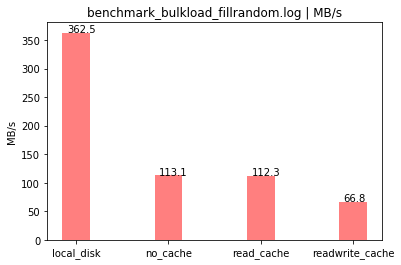

[142.2, 48.9, 48.5, 29.0]


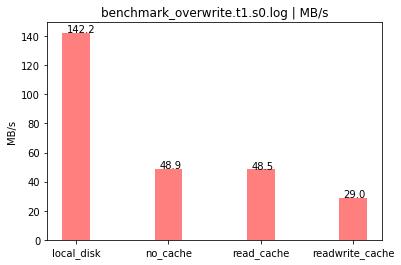

[33.8, 3.9, 16.7, 15.7]


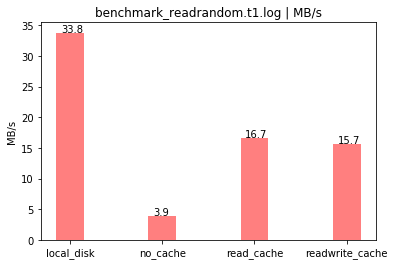

In [24]:
plot_benchmark(root_dir, disk_names, log_file_names, [LOG_RES_THROUGHPUT], 'r')

[0.51, 0.52, 0.52, 0.52]


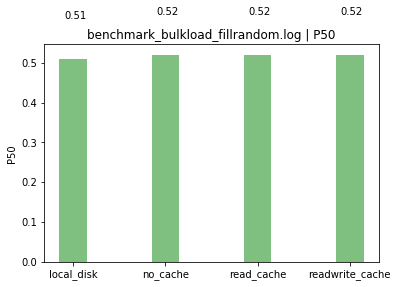

[1.61, 1.87, 1.92, 1.94]


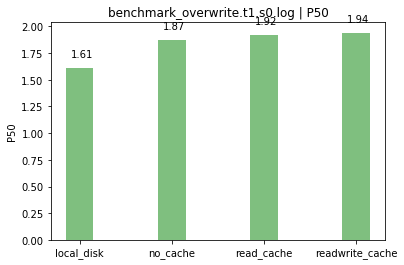

[8.85, 8.29, 8.13, 8.23]


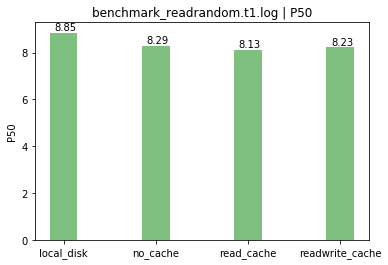

In [25]:
plot_benchmark(root_dir, disk_names, log_file_names, [LOG_RES_P50], 'g')

[1.78, 2.61, 2.6, 3.53]


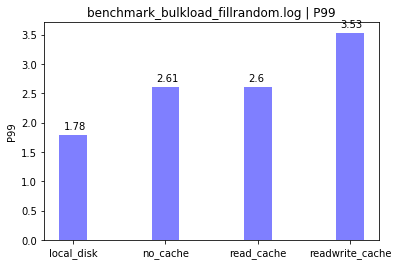

[5.96, 14.21, 13.97, 19.97]


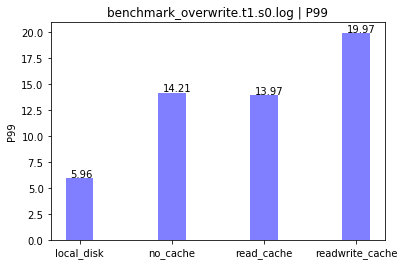

[33.2, 3750.95, 347.47, 352.23]


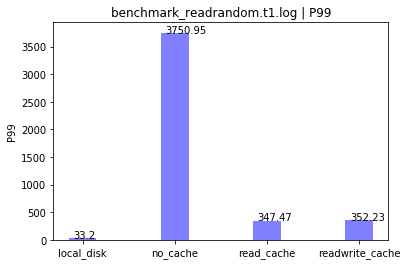

In [26]:
plot_benchmark(root_dir, disk_names, log_file_names, [LOG_RES_P99], 'b')

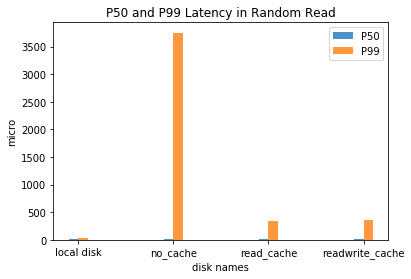

In [60]:
#plot P50 and P99 together
#def plot_bar2(y_label, title, metrics_names, disk_results, x_label, disk_names):
plot_bar2("micro", "P50 and P99 Latency in Random Read", ["P50", "P99"], 
         [[8.85, 8.29, 8.13, 8.23], [33.2, 3750.95, 347.47, 352.23]], 
          "disk names", ["local disk", "no_cache", "read_cache", "readwrite_cache"])

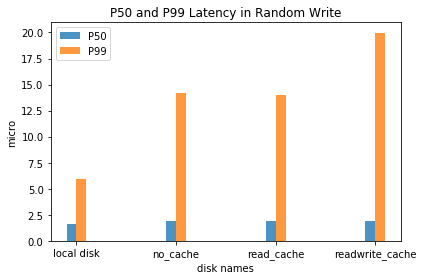

In [32]:
plot_bar2("micro", "P50 and P99 Latency in Random Write", ["P50", "P99"], 
         [[1.61, 1.87, 1.92, 1.94], [5.96, 14.21, 13.97, 19.97]], 
          "disk names", ["local disk", "no_cache", "read_cache", "readwrite_cache"])

In [61]:
#test warm-up latency
log_file_names2 = [ "benchmark_overwrite.t1.s0.log"]
disk_names2 = ["read_cache", "warm_up_latency_after_mount_movement", "warm_up_latency_after_clone"]

[48.5, 42.4, 47.7]


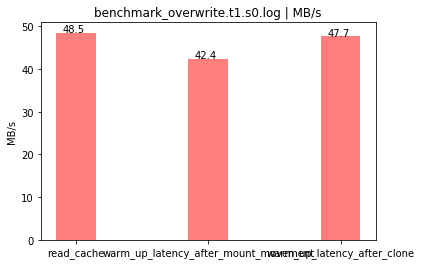

In [62]:
plot_benchmark(root_dir, disk_names2, log_file_names2, [LOG_RES_THROUGHPUT], 'r')

[13.97, 11.83, 11.06]


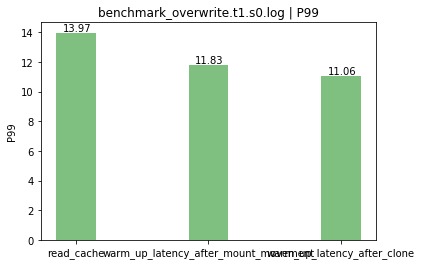

In [63]:
plot_benchmark(root_dir, disk_names2, log_file_names2, [LOG_RES_P99], 'g')

[73.5, 114.5, 114.1]


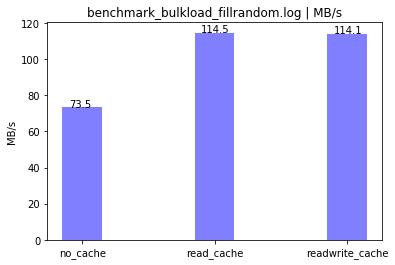

[67.4, 84.0, 76.3]


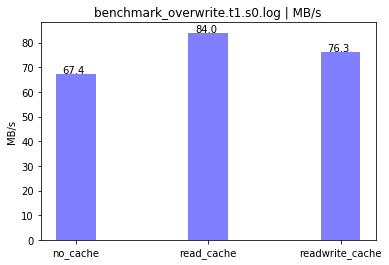

[16.4, 4.1, 16.5]


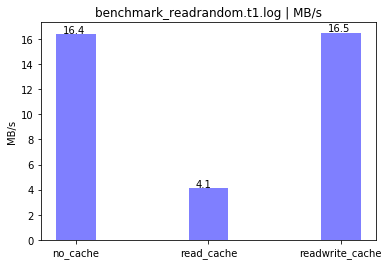

In [13]:
root_dir="/home/fxie/samza-azure-storage/milestone2/results/rocks_db_benchmark_results5_wbs_512"
plot_benchmark(root_dir, ["no_cache", "read_cache", "readwrite_cache"], log_file_names, [LOG_RES_THROUGHPUT], 'b')

#bulkload
#[73.5, 114.5, 114.1]
#113.1, 112.3, 66.8



#overwrite
#[ 48.9, 48.5, 29.0]
#[67.4, 84.0, 76.3]


#random read
#[3.9, 16.7, 15.7]
#[16.4, 4.1, 16.5]

In [8]:
#for test_dir in ["/read_cache2", "/readwrite_cache", "/read_cache"]:
    #test_data_disk_bulk_and_overwrite_with_compression(test_dir)

[0.52, 0.56, 0.56]


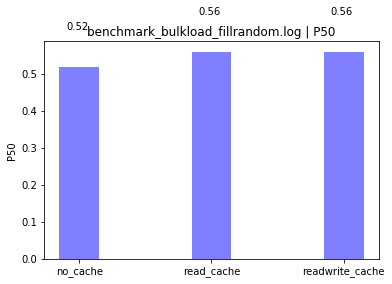

[3.03, 2.9, 2.95]


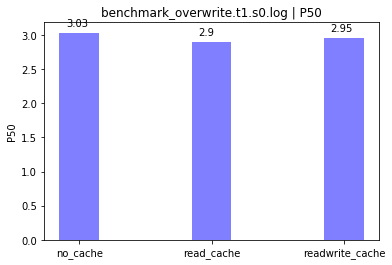

[8.5, 9.62, 8.71]


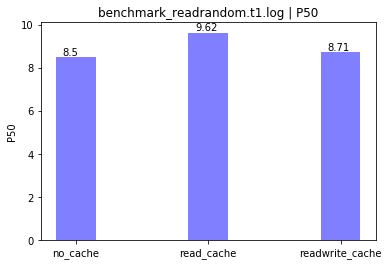

In [34]:
root_dir="/home/fxie/samza-azure-storage/milestone2/results/rocks_db_benchmark_results5_wbs_512"
plot_benchmark(root_dir, ["no_cache", "read_cache", "readwrite_cache"], log_file_names, [LOG_RES_P50], 'b')

In [7]:
#for test_dir in ["/read_cache3", "/read_cache4"]:
    #test_data_disk_bulk_and_overwrite_with_compression(test_dir, False)

[2.92, 3.89, 3.97]


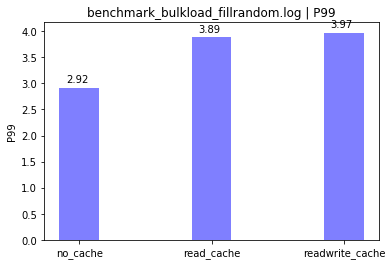

[18.62, 17.04, 18.4]


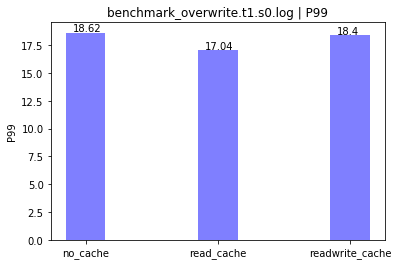

[336.16, 3272.09, 337.63]


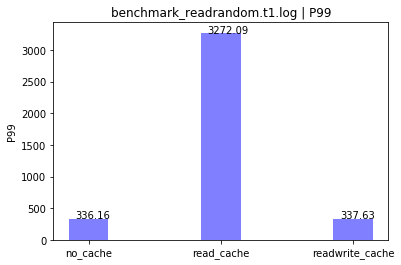

In [35]:
plot_benchmark(root_dir, ["no_cache", "read_cache", "readwrite_cache"], log_file_names, [LOG_RES_P99], 'b')

In [6]:
#local disk
#test_data_disk_bulk_and_overwrite_with_compression("/mnt")

[111.2, 64.4, 112.0]


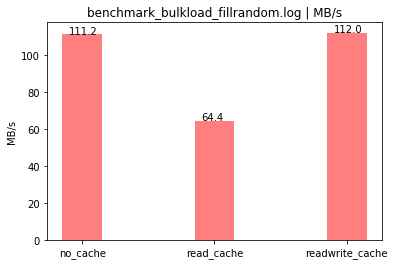

[68.0, 49.2, 68.9]


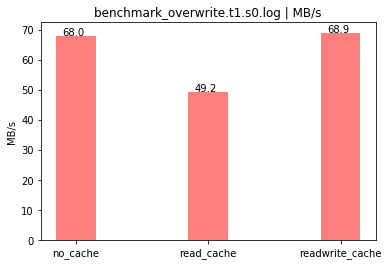

[16.8, 16.1, 4.3]


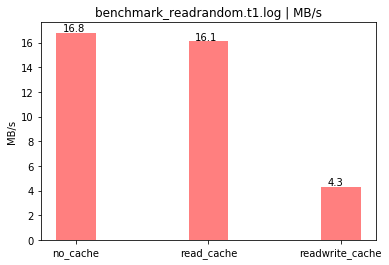

In [9]:
plot_benchmark("/home/fxie/samza-azure-storage/milestone2/results/rocks_db_benchmark_results5_wbs_256", 
               ["no_cache", "read_cache", "readwrite_cache"], log_file_names, [LOG_RES_THROUGHPUT], 'r')

In [4]:
#no cache
test_data_disk_bulk_and_overwrite_with_compression("/no_cache")

test dir /no_cache
Setup a new test root. Test root dir /no_cache/test-439815266
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/no_cache/test-439815266/db OUTPUT_DIR=/no_cache/test-439815266/output WAL_DIR=/no_cache/test-439815266/wal TEMP=/no_cache/test-439815266/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-02 20:52:34.390918
===== Benchmark =====
Start bulkload at Fri Aug  2 20:52:34 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/no_cache/test-439815266/db --wal_dir=/no_cache/test-439815266/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_byt

===== Benchmark =====
Start overwrite at Fri Aug  2 21:11:18 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/no_cache/test-439815266/db --wal_dir=/no_cache/test-439815266/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=134217728 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=ski

===== Benchmark =====
Start readrandom at Fri Aug  2 21:14:55 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/no_cache/test-439815266/db --wal_dir=/no_cache/test-439815266/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=134217728 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=skip_list 

In [8]:
#use a different write buffer size
for test_dir in ["/no_cache", "/read_cache", "/readwrite_cache"]:
    test_data_disk_bulk_and_overwrite_with_compression(test_dir = test_dir, write_buffer_size = 512 * MB)

test dir /no_cache
Setup a new test root. Test root dir /no_cache/test-842846066
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/no_cache/test-842846066/db OUTPUT_DIR=/no_cache/test-842846066/output WAL_DIR=/no_cache/test-842846066/wal TEMP=/no_cache/test-842846066/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=536870912 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-03 23:35:20.045334
===== Benchmark =====
Start bulkload at Sat Aug  3 23:35:20 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/no_cache/test-842846066/db --wal_dir=/no_cache/test-842846066/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_

===== Benchmark =====
Start overwrite at Sun Aug  4 00:01:47 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/no_cache/test-842846066/db --wal_dir=/no_cache/test-842846066/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=536870912 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=ski

===== Benchmark =====
Start readrandom at Sun Aug  4 00:05:46 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/no_cache/test-842846066/db --wal_dir=/no_cache/test-842846066/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=536870912 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=skip_list 

Setup a new test root. Test root dir /read_cache/test-175734500
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/read_cache/test-175734500/db OUTPUT_DIR=/read_cache/test-175734500/output WAL_DIR=/read_cache/test-175734500/wal TEMP=/read_cache/test-175734500/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=536870912 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-04 00:14:35.476251
===== Benchmark =====
Start bulkload at Sun Aug  4 00:14:35 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/read_cache/test-175734500/db --wal_dir=/read_cache/test-175734500/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compa

===== Benchmark =====
Start overwrite at Sun Aug  4 00:33:41 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/read_cache/test-175734500/db --wal_dir=/read_cache/test-175734500/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=536870912 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep

Setup a new test root. Test root dir /readwrite_cache/test-325346256
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/readwrite_cache/test-325346256/db OUTPUT_DIR=/readwrite_cache/test-325346256/output WAL_DIR=/readwrite_cache/test-325346256/wal TEMP=/readwrite_cache/test-325346256/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=536870912 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-04 01:11:44.105432
===== Benchmark =====
Start bulkload at Sun Aug  4 01:11:44 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/readwrite_cache/test-325346256/db --wal_dir=/readwrite_cache/test-325346256/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --

===== Benchmark =====
Start overwrite at Sun Aug  4 01:30:23 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/readwrite_cache/test-325346256/db --wal_dir=/readwrite_cache/test-325346256/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=536870912 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --m

===== Benchmark =====
Start readrandom at Sun Aug  4 01:32:48 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/readwrite_cache/test-325346256/db --wal_dir=/readwrite_cache/test-325346256/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=536870912 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtable

In [6]:
test_data_disk_bulk_and_overwrite_with_compression(test_dir = "/read_cache2", write_buffer_size = 512 * MB)

test dir /read_cache2
Setup a new test root. Test root dir /read_cache2/test-915426253
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/read_cache2/test-915426253/db OUTPUT_DIR=/read_cache2/test-915426253/output WAL_DIR=/read_cache2/test-915426253/wal TEMP=/read_cache2/test-915426253/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=536870912 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-05 17:10:56.910152
===== Benchmark =====
Start bulkload at Mon Aug  5 17:10:56 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/read_cache2/test-915426253/db --wal_dir=/read_cache2/test-915426253/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compre

===== Benchmark =====
Start overwrite at Mon Aug  5 17:29:57 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/read_cache2/test-915426253/db --wal_dir=/read_cache2/test-915426253/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=536870912 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtabler

===== Benchmark =====
Start readrandom at Mon Aug  5 17:32:37 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/read_cache2/test-915426253/db --wal_dir=/read_cache2/test-915426253/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=536870912 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=skip

array([1., 1., 1.])

In [4]:
for test_dir in ["/no_cache3", "/read_cache3", "/readwrite_cache3"]:
    test_data_disk_bulk_and_overwrite_with_compression(test_dir = test_dir, write_buffer_size = 256 * MB)

test dir /no_cache3
Setup a new test root. Test root dir /no_cache3/test-755232287
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/no_cache3/test-755232287/db OUTPUT_DIR=/no_cache3/test-755232287/output WAL_DIR=/no_cache3/test-755232287/wal TEMP=/no_cache3/test-755232287/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=268435456 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-06 04:45:48.859027
===== Benchmark =====
Start bulkload at Tue Aug  6 04:45:48 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/no_cache3/test-755232287/db --wal_dir=/no_cache3/test-755232287/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none 

===== Benchmark =====
Start overwrite at Tue Aug  6 05:04:41 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/no_cache3/test-755232287/db --wal_dir=/no_cache3/test-755232287/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=268435456 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=s

===== Benchmark =====
Start readrandom at Tue Aug  6 05:07:22 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/no_cache3/test-755232287/db --wal_dir=/no_cache3/test-755232287/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=268435456 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=skip_lis

Setup a new test root. Test root dir /read_cache3/test-337607663
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/read_cache3/test-337607663/db OUTPUT_DIR=/read_cache3/test-337607663/output WAL_DIR=/read_cache3/test-337607663/wal TEMP=/read_cache3/test-337607663/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=268435456 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-06 05:15:59.553809
===== Benchmark =====
Start bulkload at Tue Aug  6 05:15:59 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/read_cache3/test-337607663/db --wal_dir=/read_cache3/test-337607663/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --leve

===== Benchmark =====
Start overwrite at Tue Aug  6 05:44:26 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/read_cache3/test-337607663/db --wal_dir=/read_cache3/test-337607663/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=268435456 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtabler

===== Benchmark =====
Start readrandom at Tue Aug  6 05:48:36 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/read_cache3/test-337607663/db --wal_dir=/read_cache3/test-337607663/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=268435456 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtablerep=skip

Setup a new test root. Test root dir /readwrite_cache3/test-455614172
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/readwrite_cache3/test-455614172/db OUTPUT_DIR=/readwrite_cache3/test-455614172/output WAL_DIR=/readwrite_cache3/test-455614172/wal TEMP=/readwrite_cache3/test-455614172/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=268435456 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-06 05:57:36.224655
===== Benchmark =====
Start bulkload at Tue Aug  6 05:57:36 UTC 2019
Bulk loading 125000000 random keys
./db_bench --benchmarks=fillrandom --use_existing_db=0 --disable_auto_compactions=1 --sync=0 --db=/readwrite_cache3/test-455614172/db --wal_dir=/readwrite_cache3/test-455614172/wal --num=125000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio

===== Benchmark =====
Start overwrite at Tue Aug  6 06:16:52 UTC 2019
Do 25000000 random overwrite
./db_bench --benchmarks=overwrite --use_existing_db=1 --sync=0 --db=/readwrite_cache3/test-455614172/db --wal_dir=/readwrite_cache3/test-455614172/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=268435456 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 -

===== Benchmark =====
Start readrandom at Tue Aug  6 06:19:29 UTC 2019
Reading 25000000 random keys
./db_bench --benchmarks=readrandom --use_existing_db=1 --db=/readwrite_cache3/test-455614172/db --wal_dir=/readwrite_cache3/test-455614172/wal --num=25000000 --disable_wal=true --num_levels=6 --key_size=20 --value_size=400 --block_size=8192 --cache_size=104857600 --cache_numshardbits=6 --compression_max_dict_bytes=0 --compression_ratio=0.5 --compression_type=none --level_compaction_dynamic_level_bytes=true --bytes_per_sync=8388608 --cache_index_and_filter_blocks=0 --pin_l0_filter_and_index_blocks_in_cache=1 --benchmark_write_rate_limit=0 --hard_rate_limit=3 --rate_limit_delay_max_milliseconds=1000000 --write_buffer_size=268435456 --target_file_size_base=134217728 --max_bytes_for_level_base=1073741824 --verify_checksum=1 --delete_obsolete_files_period_micros=62914560 --max_bytes_for_level_multiplier=8 --statistics=0 --stats_per_interval=1 --stats_interval_seconds=60 --histogram=1 --memtab

In [5]:
for test_dir in ["/no_cache4", "/read_cache4", "/readwrite_cache4"]:
    test_data_disk_bulk_and_overwrite_with_compression(test_dir = test_dir, write_buffer_size = 32 * MB)

test dir /no_cache4
Setup a new test root. Test root dir /no_cache4/test-19016545
running bulk load
 KEY_SIZE=20 VALUE_SIZE=400 DB_DIR=/no_cache4/test-19016545/db OUTPUT_DIR=/no_cache4/test-19016545/output WAL_DIR=/no_cache4/test-19016545/wal TEMP=/no_cache4/test-19016545/tmp COMPRESSION_TYPE=none CACHE_SIZE=104857600 NUM_KEYS=125000000 WRITE_BUFFER_SIZE=33554432 /home/fxie/rocksdb/tools/benchmark.sh bulkload
iostat monitor thread : iostat-bulkload start. timestamp : 2019-08-06 06:52:58.765062
iostat monitor thread : iostat-bulkload end. timestamp : 2019-08-06 16:50:55.381202


KeyboardInterrupt: 